In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sagemaker
import boto3
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None) # To display all columns
pd.set_option('display.max_rows',None) # To display all columns
client = boto3.client('s3')
import feather
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from functools import reduce

In [2]:
df=pd.read_feather('s3://haseebdata/Dataset/Dataset.ftr')
questions_df = pd.read_feather('s3://haseebdata/Dataset/dfq.ftr')

In [3]:
df2 = K1[K1['question_id'].notnull()]
questions_df.question_id = questions_df.question_id.str.slice(start=1)

In [6]:
questions_df.bundle_id = questions_df.bundle_id.str.slice(start=1)
questions_df.explanation_id = questions_df.explanation_id.str.slice(start=1)
questions_df.deployed_at = pd.to_datetime(questions_df.deployed_at, unit='ms')
dfq = questions_df[['question_id', 'correct_answer', 'bundle_id', 'explanation_id' ,  'part', 'tags', 'deployed_at']]


In [7]:
#dfq.to_feather('questions.ftr')

In [8]:
#df2.to_feather('Dataset.ftr')

In [9]:
df['user_iD'].nunique()

784309

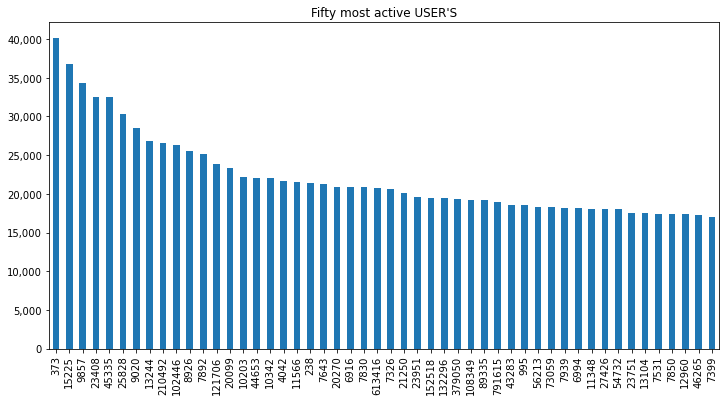

In [10]:
cids = df.user_iD.value_counts()[:50]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Fifty most active USER'S")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [11]:
df.dtypes

timestamp        int64
solving_id       int64
question_id      int32
user_answer     object
elapsed_time     int64
user_iD          int32
dtype: object

In [13]:
questions_df.dtypes

question_id                int32
correct_answer            object
bundle_id                  int32
explanation_id             int32
part                       int32
tags                      object
deployed_at       datetime64[ns]
dtype: object

In [14]:
# left join student dataframe and answer key dataframe on the 'question_id' column 
dfm = pd.merge(df, questions_df,  how='left', left_on=['question_id'], right_on = ['question_id'])

In [15]:
# create a 'correct' column
dfm['correct'] = np.nan

# loop - if user answers == correct answer, then dfq['correct'][_]= 1
length_df = dfm['user_iD'].count()
count = 0
for i in range(length_df):
    if dfm['user_answer'][count] == dfm['correct_answer'][count]:
        dfm['correct'][count] = 1
    if dfm['user_answer'][count] != dfm['correct_answer'][count]:
        dfm['correct'][count] = 0
    count+=1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
dfm.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD,correct_answer,bundle_id,explanation_id,part,tags,deployed_at,correct
0,1565096190868,1,5012,b,38000,1,c,3544,3544,5,74,2019-09-17 02:43:28.616,0.0
1,1565096221062,2,4706,c,24000,1,c,3238,3238,5,71,2019-10-30 05:34:30.723,1.0
2,1565096293432,3,4366,b,68000,1,b,2898,2898,5,103,2019-10-30 05:37:51.451,1.0
3,1565096339668,4,4829,a,42000,1,c,3361,3361,5,83,2019-06-24 09:24:51.347,0.0
4,1565096401774,5,6528,b,59000,1,d,5060,5060,5,90,2019-10-17 03:03:15.009,0.0


In [17]:
dfm.dtypes

timestamp                  int64
solving_id                 int64
question_id                int32
user_answer               object
elapsed_time               int64
user_iD                    int32
correct_answer            object
bundle_id                  int32
explanation_id             int32
part                       int32
tags                      object
deployed_at       datetime64[ns]
correct                  float64
dtype: object

In [18]:
dfm.to_feather('EDNET.ftr')

In [19]:
df_total_questions_attempted = dfm.groupby(['user_iD'], as_index=False , sort=False)['question_id'].count()

df_total_questions_attempted = df_total_questions_attempted.rename(columns={'question_id': 'Total Questions Attempted'})                                                               

In [20]:
df_correct = dfm[dfm['correct']==1].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_correct = df_correct.rename(columns={'question_id': 'Corrected'})

In [21]:
df_incorrect = dfm[dfm['correct']==0].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_incorrect = df_incorrect.rename(columns={'question_id': 'Incorrected'})

In [22]:
dfs = [df_total_questions_attempted, df_correct, df_incorrect]
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [23]:
df_final['Percentage'] = (df_final['Corrected'] / df_final['Total Questions Attempted']) *100
df_final.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage
0,1,1082,753,329,69.593346
1,10,16,9,7,56.250000
2,100,33,18,15,54.545455
3,1000,1488,930,558,62.500000
4,10000,405,258,147,63.703704


In [24]:
df['elapsed_time']= df.elapsed_time.div(1000)   #DIVDING THE ELAPSED TIME by 1000 to further check the mean elapsed time by each user

In [25]:
Elapsed_time= df.groupby('user_iD' , sort=False)['elapsed_time'].median()

In [26]:
dfs = [df_final, Elapsed_time]
df2 = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [27]:
df2.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
0,1,1082,753,329,69.593346,36.75
1,10,16,9,7,56.250000,27.75
2,100,33,18,15,54.545455,34.50
3,1000,1488,930,558,62.500000,34.00
4,10000,405,258,147,63.703704,25.00


In [28]:
df2.to_feather('All_users_perform.ftr')

In [29]:
print("ALL DONE")

ALL DONE


In [30]:
df2['user_iD'].nunique()

724139

## MODELING BEGINS


In [ ]:
dfm=pd.read_feather('EDNET.ftr')

In [31]:
# list to store to scores
scores = []
algo = []

In [33]:
#Split data into testing and training datasets
import numpy as np
from sklearn.model_selection import train_test_split
X = dfm[['user_iD', 'question_id', 'solving_id', 'bundle_id', 'part','elapsed_time']]
y = dfm.correct

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## MODELING

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
#clf.predict_proba(X_train)
print(lr.score(X_test, y_test))
scores.append(lr.score(X_test, y_test))
algo.append('LogisticRegression')

0.6532601078971104


In [35]:
#clf
clf = LogisticRegression(random_state=42).fit(X, y)
clf.predict(X_test)
clf.predict_proba(X_test)
clf.score(X_test, y_test)
scores.append(clf.score(X_test, y_test))
algo.append('clf')
print(clf.score(X_test, y_test))

0.6532607756874457


In [36]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
nb.score(X,y)
scores.append(nb.score(X,y))
algo.append('GaussianNB')

In [ ]:
# Stochastic gradient descent
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='modified_huber', shuffle=True, random_state=42)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
sgd.score(X,y)
scores.append(sgd.score(X,y))
algo.append('SGDClassifier')

In [ ]:
# KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X,y)
scores.append(knn.score(X,y))
algo.append('KNeighborsClassifier')

In [ ]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfm = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=1, \
                            random_state=42, max_features = None, min_samples_leaf = 30)
rfm.fit(X_train, y_train)
y_pred = rfm.predict(X_test)
rfm.score(X,y)
scores.append(rfm.score(X,y))
algo.append('RandomForestClassifier')

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=0.025, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm.score(X,y)
scores.append(svm.score(X,y))
algo.append('SVC')

In [ ]:
print(scores)
print(algo)

In [ ]:
'LogisticRegression', 'clf', 'GaussianNB', 'SGDClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'SVC']
In [34]:
fig, ax = plt.subplots()
plt.bar(algo, scores)
plt.ylabel("Score")
plt.xlabel("Algorithm")
#plt.title('Algorithm Scores for User ' +str(z)+ ' | Max: '+str(round(max(scores),5)))
plt.xticks(rotation=40, ha="right" )

ax.grid()